In [14]:
import velvet as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

In [15]:
from scipy.ndimage import gaussian_filter
import matplotlib

import pickle 
import colorsys
import random

In [16]:
neural = sc.read_h5ad('../data/neural_data_0606.h5ad')

state_path = '../models/neural_vf_0606_model.pt'

vt.md.Velvet.setup_anndata(neural, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

INFO     Generating sequential column names                                                                        


<All keys matched successfully>

In [17]:
model.module = model.module.to('cuda')

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

markov = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True, 
    use_similarity=False
)

sde = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.1,
    device=model.device
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde,
    markov,
)


sde_state_path = '../models/neural_sde_0606_model.pt'

trained_state_sde = torch.load(sde_state_path)['model_state_dict']

sde_model.module.load_state_dict(trained_state_sde)

KNN indices for Velvet stored in .obsm['knn_index'].


<All keys matched successfully>

In [18]:
import numpy as np
from scipy.stats import t as scstt

def calc_confidence_intervals(data):
    means = np.mean(data, axis=0)
    stddevs = np.std(data, axis=0, ddof=1)
    sems = stddevs / np.sqrt(data.shape[0])

    t_values = scstt.ppf(0.975, data.shape[0]-1)
    conf_ints = t_values * sems
    return conf_ints

def get_plot_data(
    gene_expression,
    gene,
    mean_normalize=True
):
    gene_index = np.where(model.adata.var_names==gene)[0][0]
    gene_data = gene_expression[:,:,gene_index].cpu().numpy()
    
    mu = gene_data.mean(0)
    if mean_normalize:    
        mumax = mu.max()
        gene_data = gene_data / mumax
        mu = mu / mumax
        
    ci = calc_confidence_intervals(gene_data)

    return gene_data, mu, ci

In [19]:
import pickle 

with open('../data/F4_noisy0.1_trajectories.pickle', 'rb') as f:
    data = pickle.load(f)

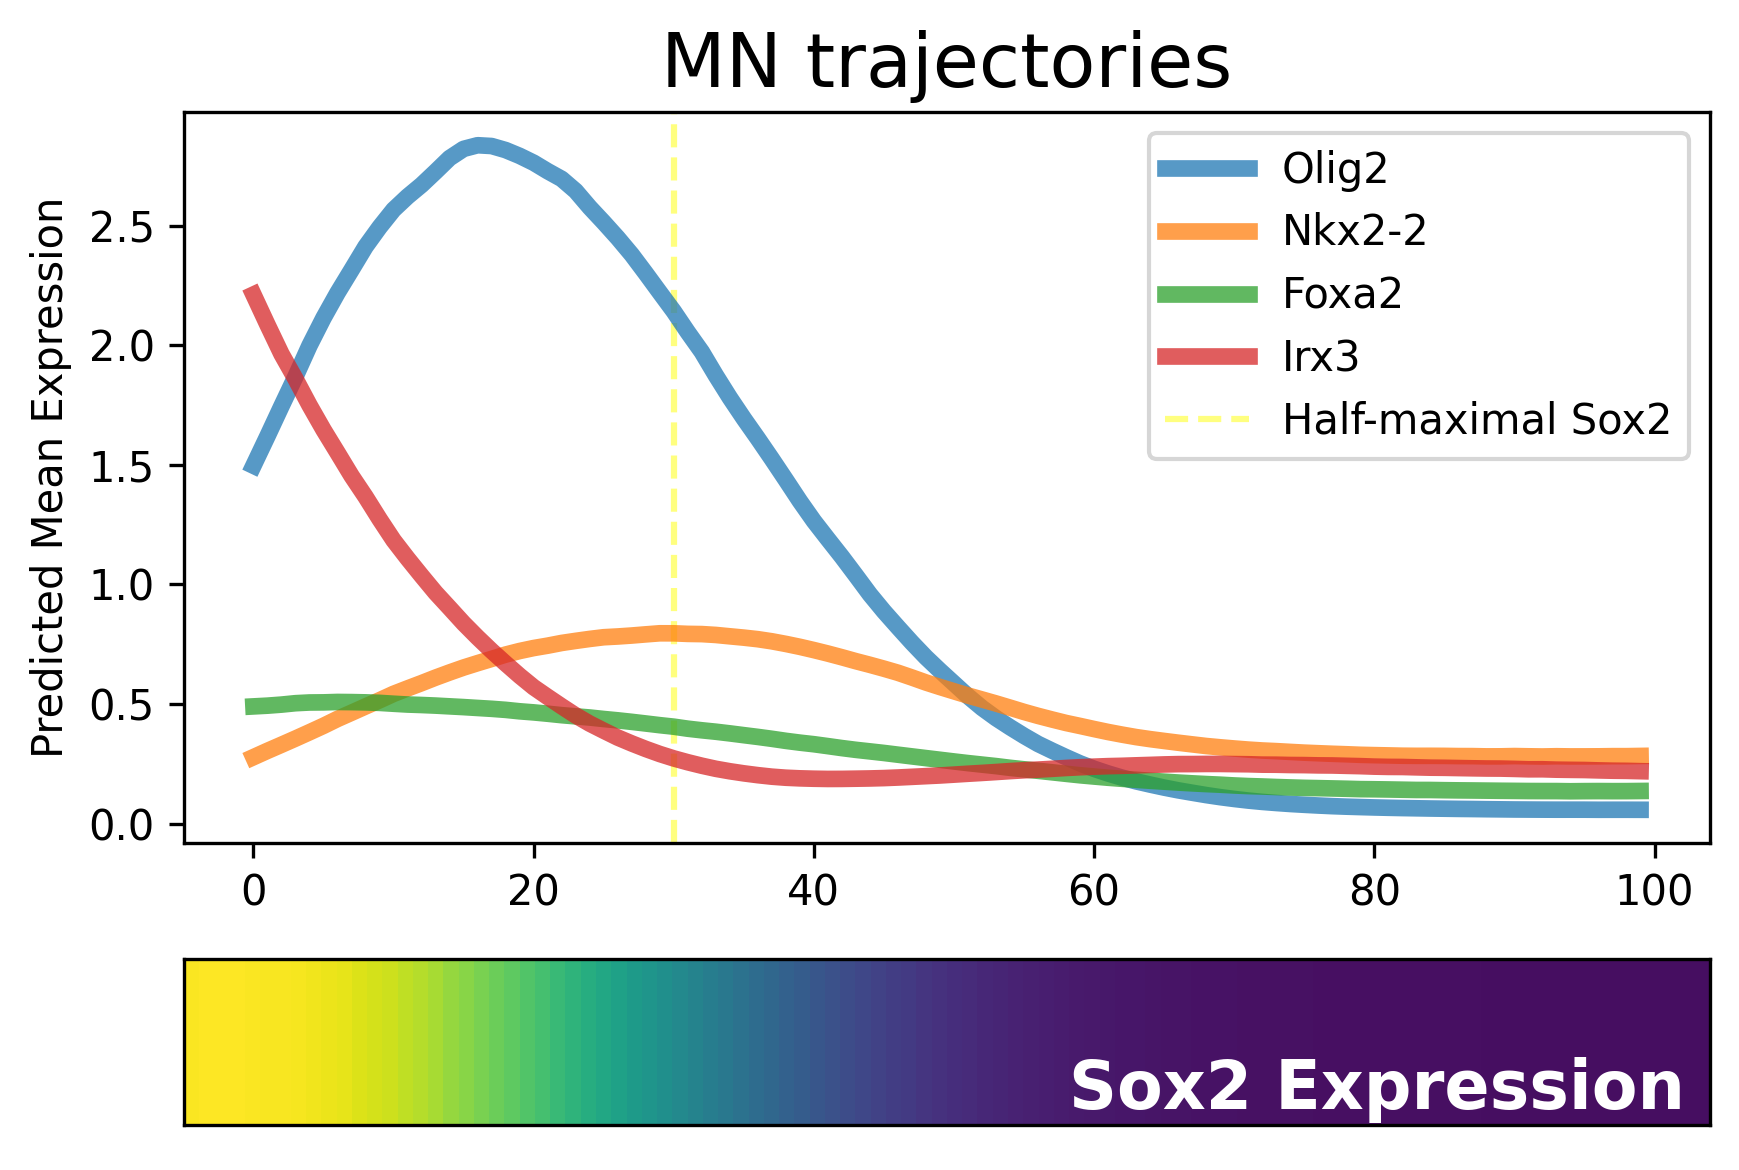

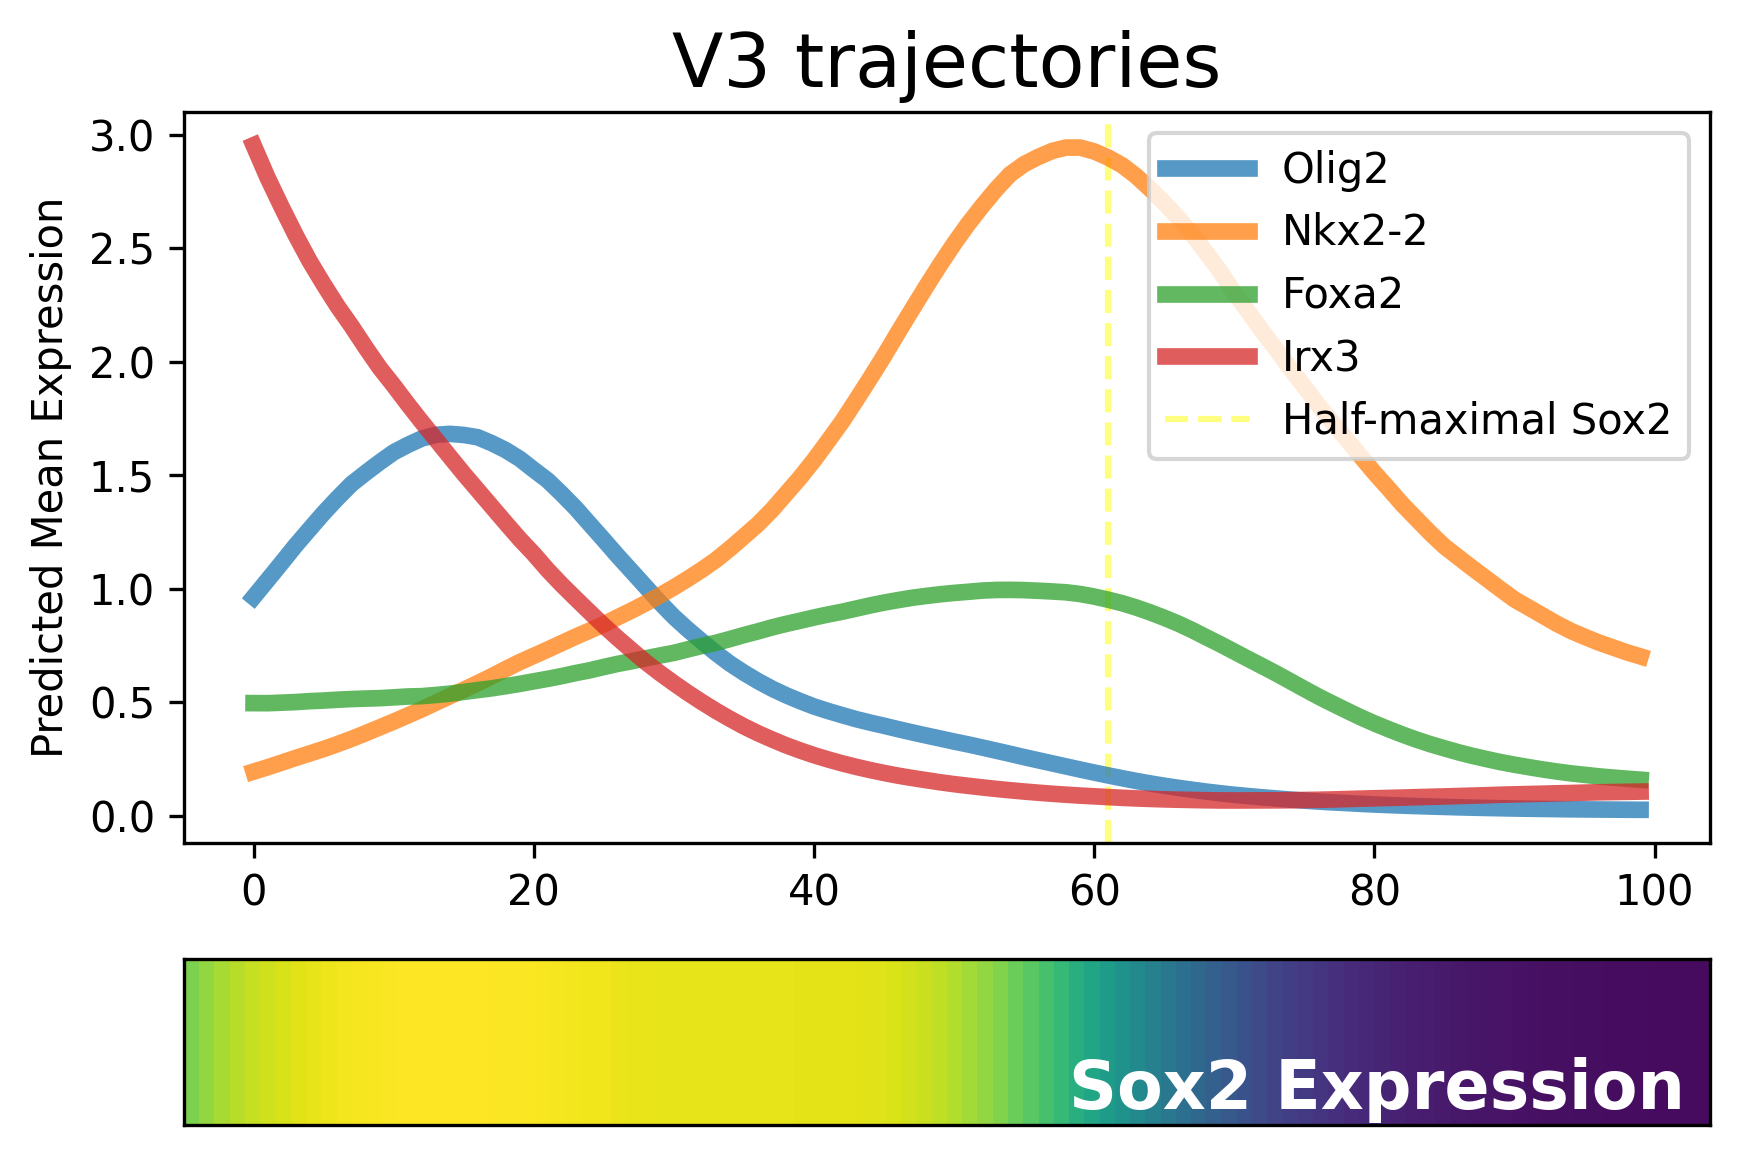

In [10]:
norm=False

for di, domain in enumerate(['MN','V3']):
    gex = model.get_trajectory_gene_expression(data[domain])
    o2, o2m, o2ci = get_plot_data(gex, 'Olig2', mean_normalize=norm)
    s2, s2m, s2ci = get_plot_data(gex, 'Sox2', mean_normalize=norm)
    n2, n2m, n2ci = get_plot_data(gex, 'Nkx2-2', mean_normalize=norm)
    f2, f2m, f2ci = get_plot_data(gex, 'Foxa2', mean_normalize=norm)
    i3, i3m, i3ci = get_plot_data(gex, 'Irx3', mean_normalize=norm)


    msc = """AAAAAAAA
    AAAAAAAA
    AAAAAAAA
    BBBBBBBB"""

    fig, axes = plt.subplot_mosaic(mosaic=msc, dpi=300, figsize=(6,4))
    axes['A'].plot(o2m, linewidth=4, label='Olig2', alpha=0.75)
    axes['A'].plot(n2m, linewidth=4, label='Nkx2-2', alpha=0.75)
    axes['A'].plot(f2m, linewidth=4, label='Foxa2', alpha=0.75)
    axes['A'].plot(i3m, linewidth=4, label='Irx3', alpha=0.75)
    axes['A'].set_title(f"{domain} trajectories", fontsize=18)
    axes['B'].imshow(s2m.reshape(1,-1), aspect='auto', vmin=0)
    axes['B'].set_xticks([])
    axes['A'].set_ylabel("Predicted Mean Expression")
    axes['B'].set_yticks([])
    axes['B'].text(57.5,0.4,'Sox2 Expression', color='white',weight='bold', fontsize=16)

    axes['A'].axvline(np.abs(s2m - (s2m.min() + ((s2m.max() - s2m.min()) / 2))).argmin(), 
                color='yellow', alpha=0.5, zorder=-10, linestyle='--',
                label='Half-maximal Sox2')
    axes['A'].legend()
    plt.tight_layout()
    for fig in plt.get_fignums():
        fig = plt.figure(fig)
        # Set the figure facecolor to transparent
        fig.patch.set_facecolor('none')
        for m in msc:
            if m in ['ABCD']:
                axes[m].set_facecolor('red', alpha=0.1)
            if m in ['EFGH']:
                axes[m].set_facecolor('blue', alpha=0.1)
            if m in ['IJKL']:
                axes[m].set_facecolor('green', alpha=0.2)

    plt.savefig(f'../figures/4.0.{di}_{domain}_expression_profile.png', bbox_inches='tight')
    plt.show()

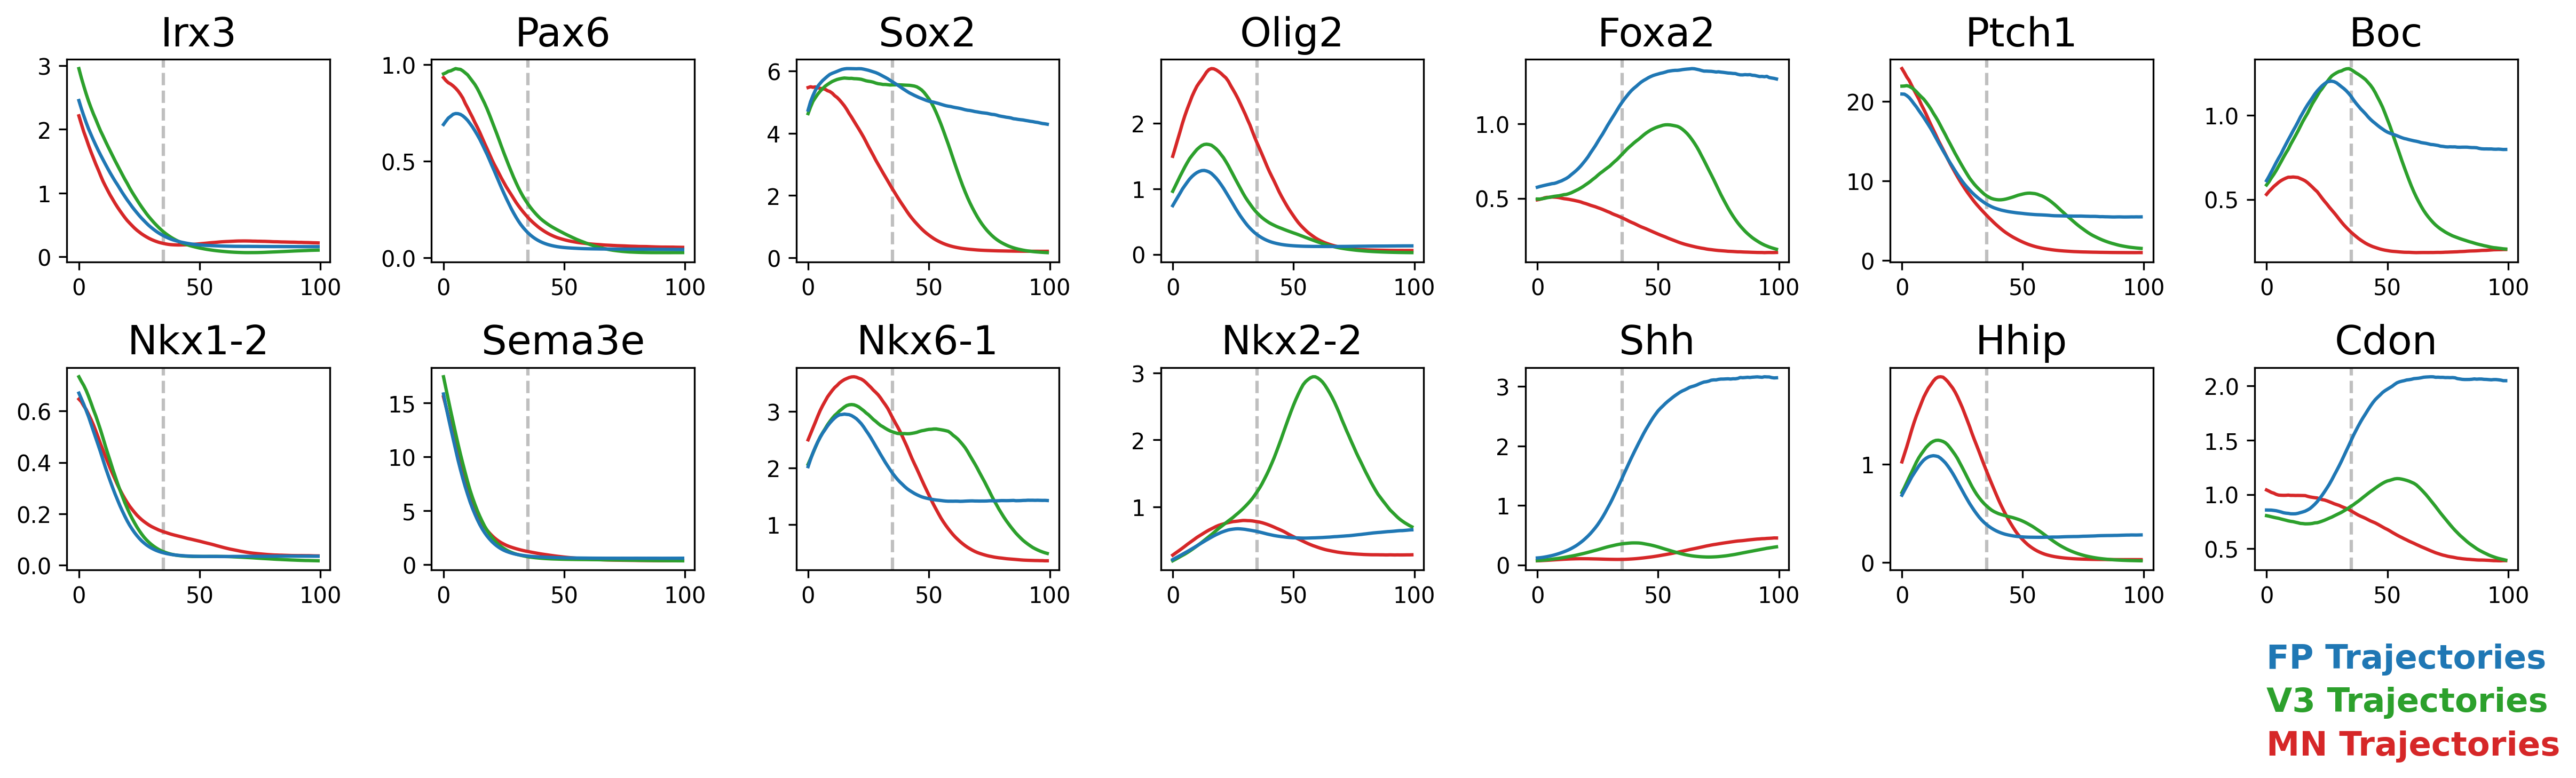

In [22]:
norm=False

genes = ['Irx3','Pax6','Sox2','Olig2','Foxa2','Ptch1','Boc','Nkx1-2','Sema3e','Nkx6-1','Nkx2-2','Shh','Hhip','Cdon']

msc = '''ABCDXY1
EFGHZ20'''
with torch.no_grad():
    vgex = model.get_trajectory_gene_expression(data['V3'])
    mgex = model.get_trajectory_gene_expression(data['MN'])
    fgex = model.get_trajectory_gene_expression(data['FP'])
    
fig, axes = plt.subplot_mosaic(mosaic=msc, figsize=(16,4), dpi=300)
for gene, x in zip(genes,msc.replace('\n','')):
    _, m, _ = get_plot_data(mgex, gene, mean_normalize=norm)
    _, v, _ = get_plot_data(vgex, gene, mean_normalize=norm)
    _, f, _ = get_plot_data(fgex, gene, mean_normalize=norm)
    axes[x].plot(m, color='tab:red')
    axes[x].plot(v, color='tab:green')
    axes[x].plot(f, color='tab:blue')
    axes[x].set_title(gene, fontsize=18)
    axes[x].axvline(x=35, zorder=-1, c='grey', alpha=0.5, linestyle='--')
plt.tight_layout()
axes['0'].text(0,-1.4,'MN Trajectories', fontweight='bold', fontsize=15, color='tab:red')
axes['0'].text(0,-1.,'V3 Trajectories', fontweight='bold', fontsize=15, color='tab:green')
axes['0'].text(0,-0.6,'FP Trajectories', fontweight='bold', fontsize=15, color='tab:blue')


for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.2_gene_portraits.png', bbox_inches='tight')

plt.show()


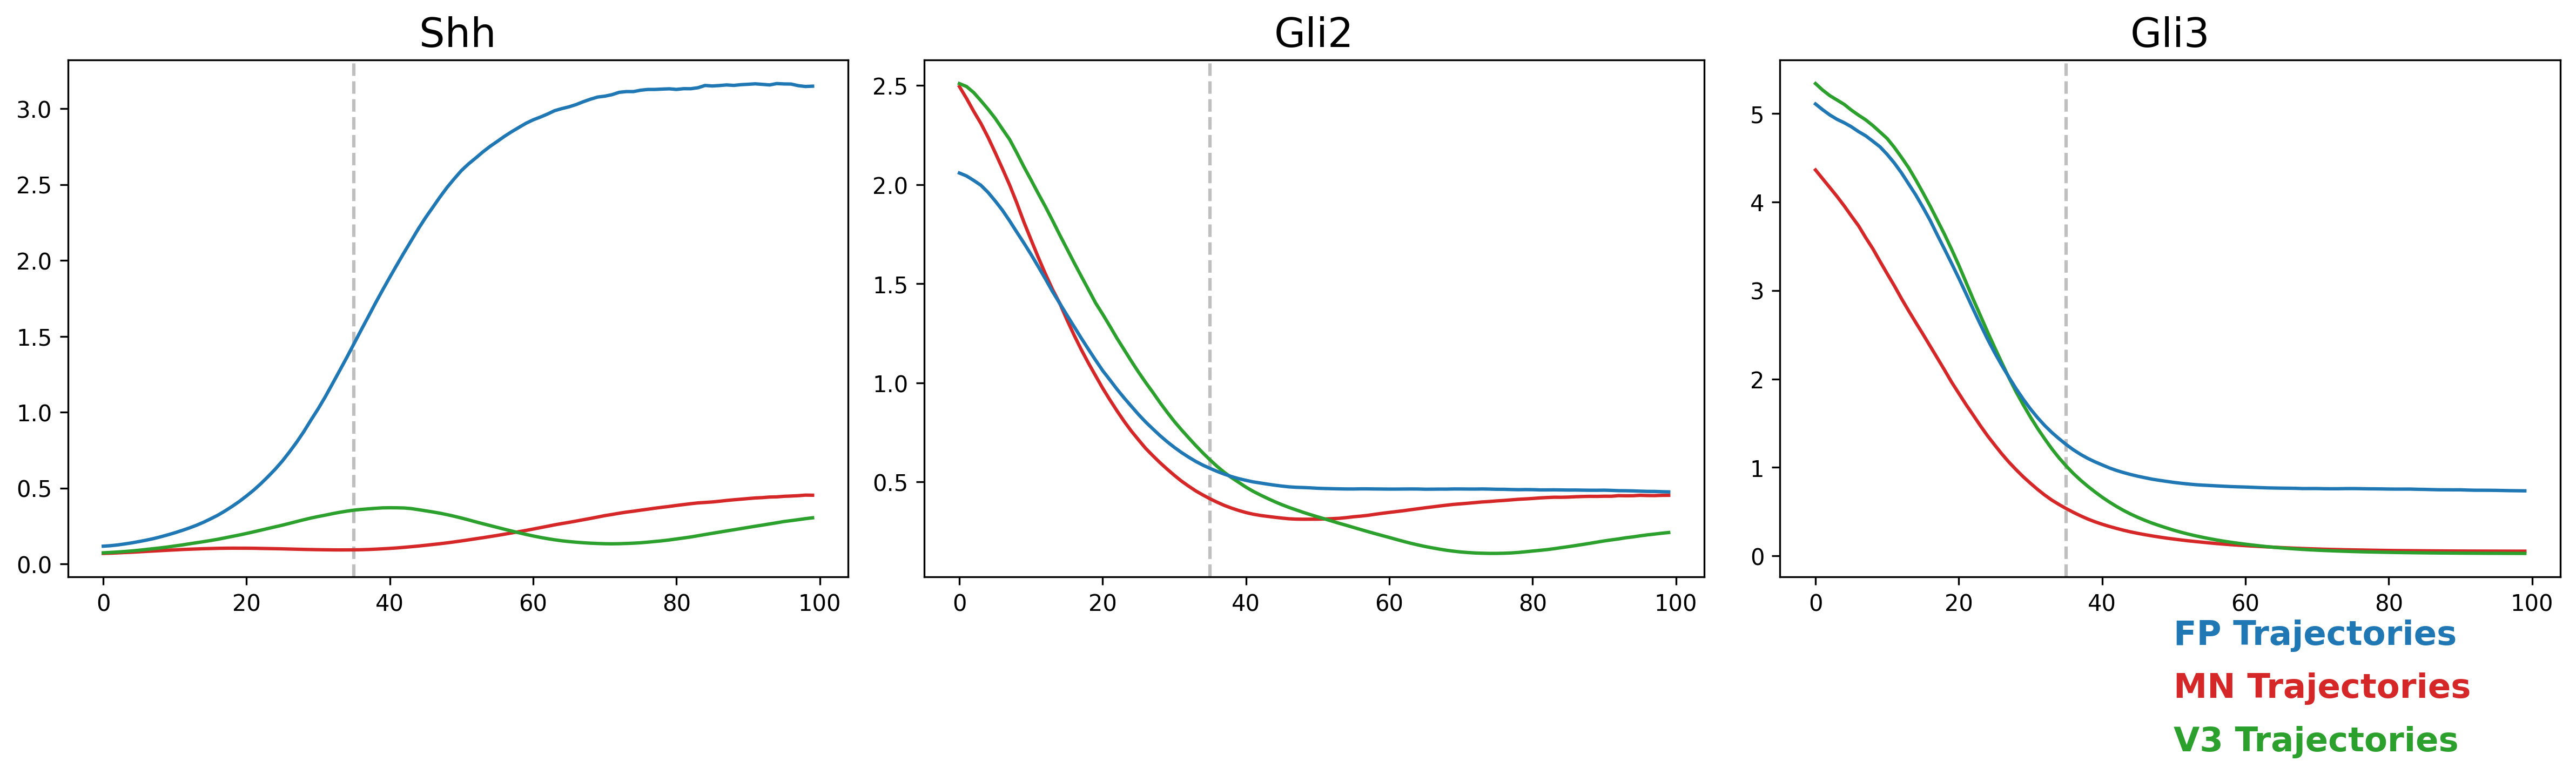

In [13]:
norm=False

genes = ['Shh','Gli2','Gli3']

msc = '''ABC'''
with torch.no_grad():
    vgex = model.get_trajectory_gene_expression(data['V3'])
    mgex = model.get_trajectory_gene_expression(data['MN'])
    fgex = model.get_trajectory_gene_expression(data['FP'])
    
fig, axes = plt.subplot_mosaic(mosaic=msc, figsize=(16,4), dpi=300)
for gene, x in zip(genes,msc.replace('\n','')):
    _, m, _ = get_plot_data(mgex, gene, mean_normalize=norm)
    _, v, _ = get_plot_data(vgex, gene, mean_normalize=norm)
    _, f, _ = get_plot_data(fgex, gene, mean_normalize=norm)
    axes[x].plot(m, color='tab:red')
    axes[x].plot(v, color='tab:green')
    axes[x].plot(f, color='tab:blue')
    axes[x].set_title(gene, fontsize=18)
    axes[x].axvline(x=35, zorder=-1, c='grey', alpha=0.5, linestyle='--')
plt.tight_layout()
axes['C'].text(50,-1.6,'MN Trajectories', fontweight='bold', fontsize=15, color='tab:red')
axes['C'].text(50,-2.2,'V3 Trajectories', fontweight='bold', fontsize=15, color='tab:green')
axes['C'].text(50,-1,'FP Trajectories', fontweight='bold', fontsize=15, color='tab:blue')


for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.9_gli.png', bbox_inches='tight')
        
plt.show()


# Timings

In [27]:
adata = neural.copy()

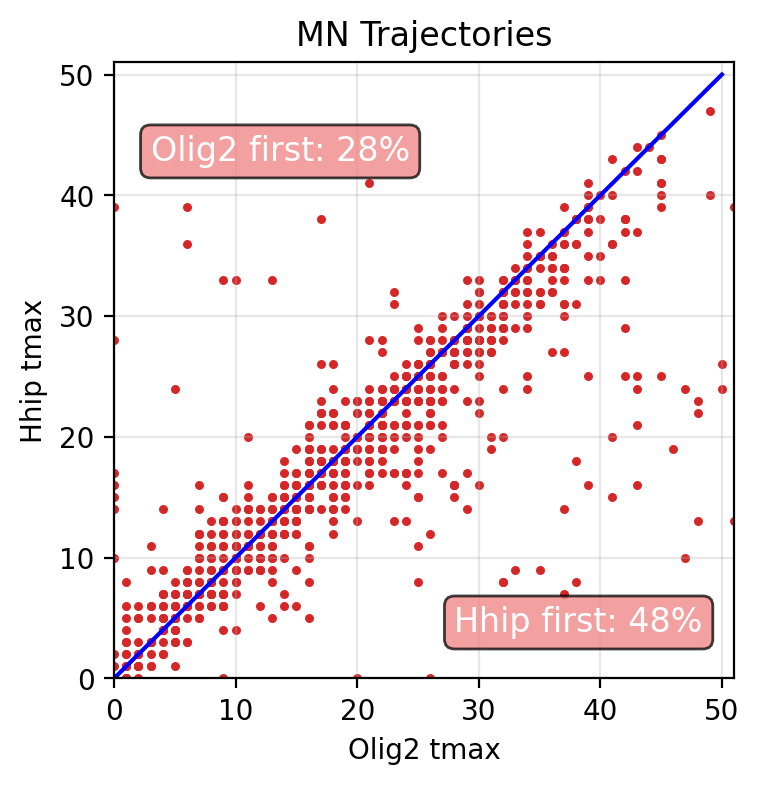

In [45]:
dom = 'MN'

gex = model.get_trajectory_gene_expression(data[dom])

a = 'Olig2'
b = 'Hhip'
A = gex[:,:,np.where(adata.var_names==a)[0][0]].argmax(1).detach().cpu().numpy()
B = gex[:,:,np.where(adata.var_names==b)[0][0]].argmax(1).detach().cpu().numpy()

plt.figure(figsize=(4,4), dpi=200)
plt.scatter(A,B,s=5, color='tab:red')
plt.plot(np.arange(A.max()),np.arange(A.max()), color='blue')
plt.ylim((0,A.max()))
plt.xlim((0,A.max()))
plt.grid(alpha=0.3, zorder=-10)
plt.xlabel(f"{a} tmax")
plt.ylabel(f"{b} tmax")

ax = plt.gca()
props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.75)  # properties for the bounding box
ax.text(3, 45, f"{a} first: {100*np.mean(A<B):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')
ax.text(28, 6, f"{b} first: {100*np.mean(B<A):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')

plt.title(f"{dom} Trajectories")

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.3_olig2_hhip_timing.png', bbox_inches='tight')


plt.show()

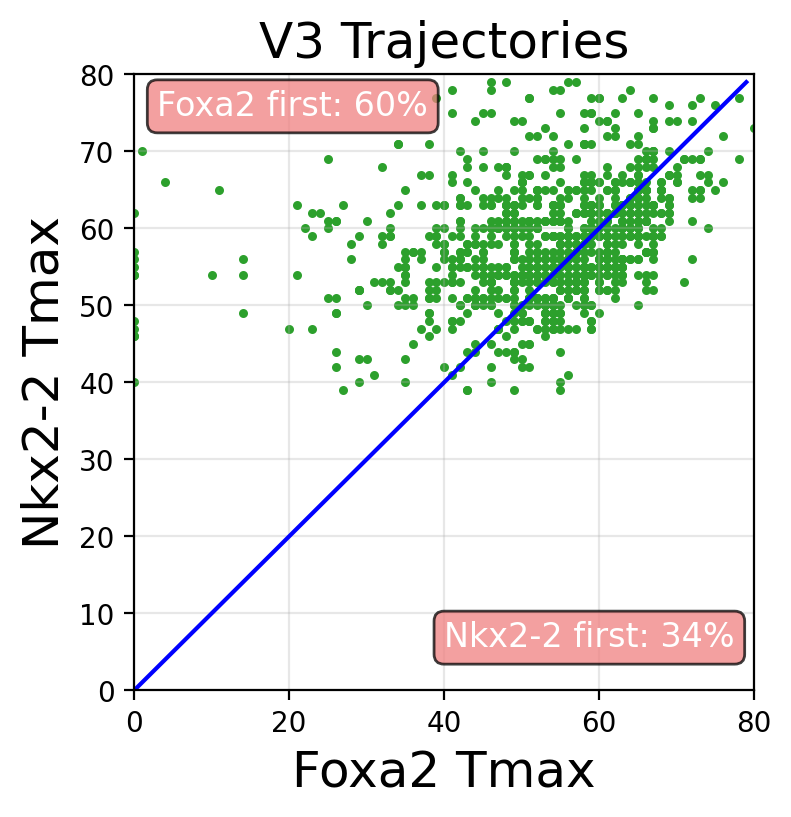

In [46]:
dom = 'V3'

gex = model.get_trajectory_gene_expression(data[dom])

a = 'Foxa2'
b = 'Nkx2-2'
A = gex[:,:,np.where(adata.var_names==a)[0][0]].argmax(1).detach().cpu().numpy()
B = gex[:,:,np.where(adata.var_names==b)[0][0]].argmax(1).detach().cpu().numpy()

plt.figure(figsize=(4,4), dpi=200)
plt.scatter(A,B,s=5, color='tab:green')
plt.plot(np.arange(A.max()),np.arange(A.max()), color='blue')
plt.ylim((0,A.max()))
plt.xlim((0,A.max()))
plt.grid(alpha=0.3, zorder=-10)
plt.xlabel(f"{a} Tmax", fontsize=18)
plt.ylabel(f"{b} Tmax", fontsize=18)

ax = plt.gca()
props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.75)  # properties for the bounding box
ax.text(3, 78, f"{a} first: {100*np.mean(A<B):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')
ax.text(40, 9, f"{b} first: {100*np.mean(B<A):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')

plt.title(f"{dom} Trajectories", fontsize=18)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.4_foxa2_nkx22_timing.png', bbox_inches='tight')


plt.show()

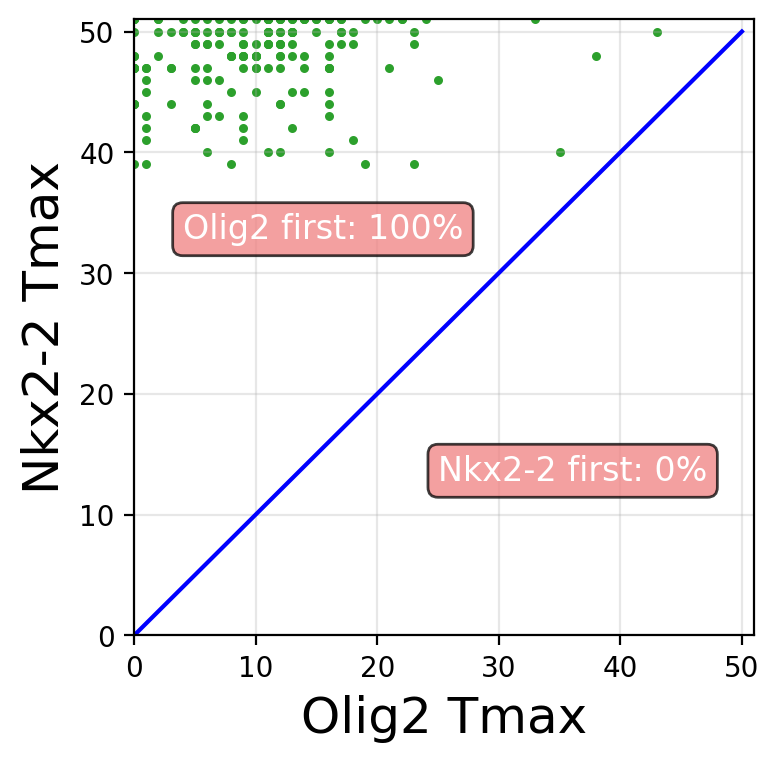

In [47]:
dom = 'V3'

gex = model.get_trajectory_gene_expression(data[dom])

a = 'Olig2'
b = 'Nkx2-2'
A = gex[:,:,np.where(adata.var_names==a)[0][0]].argmax(1).detach().cpu().numpy()
B = gex[:,:,np.where(adata.var_names==b)[0][0]].argmax(1).detach().cpu().numpy()

plt.figure(figsize=(4,4), dpi=200)
plt.scatter(A,B,s=5, color='tab:green')
plt.plot(np.arange(A.max()),np.arange(A.max()), color='blue')
plt.ylim((0,A.max()))
plt.xlim((0,A.max()))
plt.grid(alpha=0.3, zorder=-10)
plt.xlabel(f"{a} Tmax", fontsize=18)
plt.ylabel(f"{b} Tmax", fontsize=18)

ax = plt.gca()
props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.75)  # properties for the bounding box
ax.text(4, 35, f"{a} first: {100*np.mean(A<B):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')
ax.text(25, 15, f"{b} first: {100*np.mean(B<A):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')

plt.title(f"")

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.5_nkx22_olig2.png', bbox_inches='tight')

plt.show()

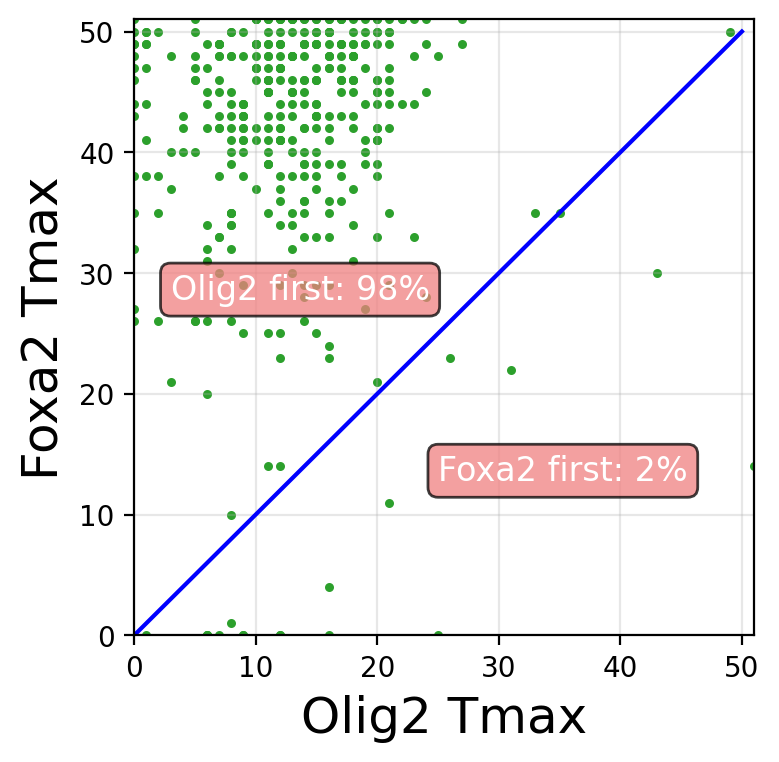

In [48]:
dom = 'V3'

gex = model.get_trajectory_gene_expression(data[dom])

a = 'Olig2'
b = 'Foxa2'
A = gex[:,:,np.where(adata.var_names==a)[0][0]].argmax(1).detach().cpu().numpy()
B = gex[:,:,np.where(adata.var_names==b)[0][0]].argmax(1).detach().cpu().numpy()

plt.figure(figsize=(4,4), dpi=200)
plt.scatter(A,B,s=5, color='tab:green')
plt.plot(np.arange(A.max()),np.arange(A.max()), color='blue')
plt.ylim((0,A.max()))
plt.xlim((0,A.max()))
plt.grid(alpha=0.3, zorder=-10)
plt.xlabel(f"{a} Tmax", fontsize=18)
plt.ylabel(f"{b} Tmax", fontsize=18)

ax = plt.gca()
props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.75)  # properties for the bounding box
ax.text(3, 30, f"{a} first: {100*np.mean(A<B):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')
ax.text(25, 15, f"{b} first: {100*np.mean(B<A):.0f}%", fontsize=12, verticalalignment='top', bbox=props, color='white')

plt.title(f"")

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.6_foxa2_olig2_timing.png', bbox_inches='tight')

plt.show()

# Time progression

In [20]:
def assign(trajectories, data):
    sdtw = SoftDTW(use_cuda=True, gamma=0.1)
    mn_ref = data['MN'].median(0).values.unsqueeze(0).repeat(trajectories.shape[0],1,1)
    v3_ref = data['V3'].median(0).values.unsqueeze(0).repeat(trajectories.shape[0],1,1)
    fp_ref = data['FP'].median(0).values.unsqueeze(0).repeat(trajectories.shape[0],1,1)
    
    scores = []
    for f in (mn_ref, v3_ref, fp_ref):
        scores.append(sdtw(trajectories, f))
    scores = torch.vstack(scores) 
    return np.array(['MN','V3','FP'])[scores.argmin(0).detach().cpu().numpy()]

In [21]:
model.adata.obs['cell_type'] = ['Progenitor' if a in ['p3','pMN','Neural'] else 'Neuron' 
                                for a in model.adata.obs.cell_annotation]

progenitors = model.adata[model.adata.obs.cell_type=='Progenitor']

In [22]:
with open('../data/F4_noisy0.1_trajectories.pickle', 'rb') as f:
    traj_data = pickle.load(f)

In [9]:
# this is a script in the analysis directory,
# from https://github.com/Maghoumi/pytorch-softdtw-cuda
from sdtw import SoftDTW

mn_prob = []
v3_prob = []
fp_prob = []
tres = []
for i, tp in enumerate(['D4','D5','D6','D7','D8']):
    cells = progenitors[progenitors.obs.timepoint==tp].obs_names
    times = int(tp.replace("D",""))
    tres.append(times)
    
    init = torch.tensor(model.adata[cells].obsm['X_z'], device=model.device)
    
    with torch.no_grad():
        trajectories, cell_ids = sde_model.simulate(
            initial_cells=init,
            n_samples_per_cell=1,
            n_steps = 100,
            t_max = 100,
            dt = 1.0,
            latent_key='X_z',
            n_chunks=10
        )

        fates = assign(trajectories, traj_data)
    
    mn_prob.append(np.mean(fates=='MN'))
    v3_prob.append(np.mean(fates=='V3'))
    fp_prob.append(np.mean(fates=='FP'))

Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s]


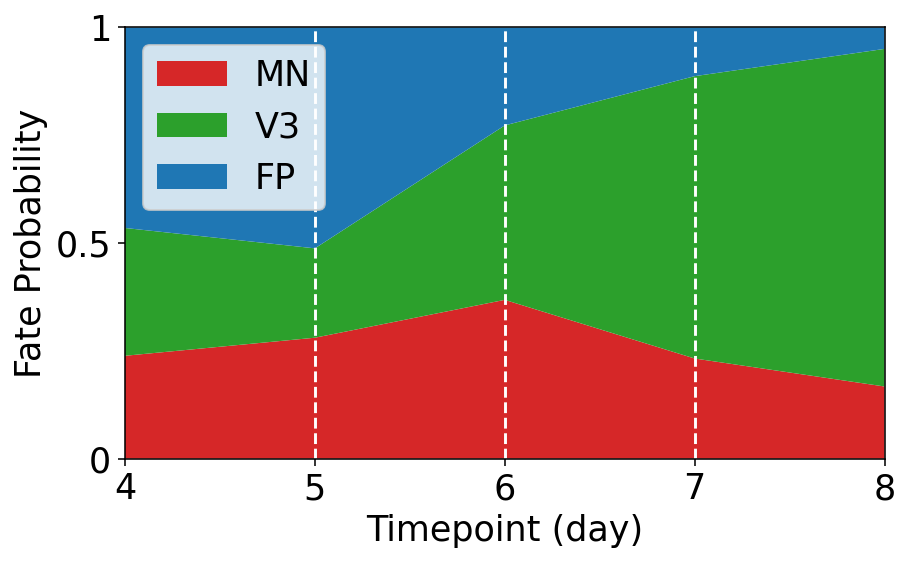

In [12]:
plt.figure(figsize=(7,4), dpi=140)
plt.stackplot(tres, mn_prob, v3_prob, fp_prob, labels=['MN','V3','FP'], colors=['tab:red','tab:green','tab:blue'])
plt.legend(loc='upper left', fontsize=18)
plt.ylim((0,1))
plt.axvline(x=5, color='white', linestyle='--')
plt.axvline(x=6, color='white', linestyle='--')
plt.axvline(x=7, color='white', linestyle='--')
plt.xlabel("Timepoint (day)", fontsize=18)
plt.ylabel("Fate Probability", fontsize=18)
plt.xlim((4,8))
plt.xticks([4,5,6,7,8],[4,5,6,7,8],fontsize=18)
plt.yticks([0,0.5,1],[0,0.5,1],fontsize=18)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
plt.savefig('../figures/4.0.7_temporal_progression.png', bbox_inches='tight')

plt.show()

In [32]:
# this is a script in the analysis directory,
# from https://github.com/Maghoumi/pytorch-softdtw-cuda
from sdtw import SoftDTW

mn_prob = []
v3_prob = []
fp_prob = []
tres = []
cres = []
for i, tp in enumerate(['D4','D5','D6','D7','D8']):
    celldata = progenitors[progenitors.obs.timepoint==tp].copy()
    cells = celldata.obs_names
    times = int(tp.replace("D",""))
    tres.append(times)
    
    init = torch.tensor(model.adata[cells].obsm['X_z'], device=model.device)
    
    with torch.no_grad():
        trajectories, cell_ids = sde_model.simulate(
            initial_cells=init,
            n_samples_per_cell=1,
            n_steps = 100,
            t_max = 100,
            dt = 1.0,
            latent_key='X_z',
            n_chunks=10
        )

        fates = assign(trajectories, traj_data)
    
    mn_prob.append(np.mean(fates=='MN'))
    v3_prob.append(np.mean(fates=='V3'))
    fp_prob.append(np.mean(fates=='FP'))
    
    celldata.obs['FATE'] = fates
    cres.append(celldata)

Simulating Chunk 9: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]


In [37]:
dat = ann.concat(cres)

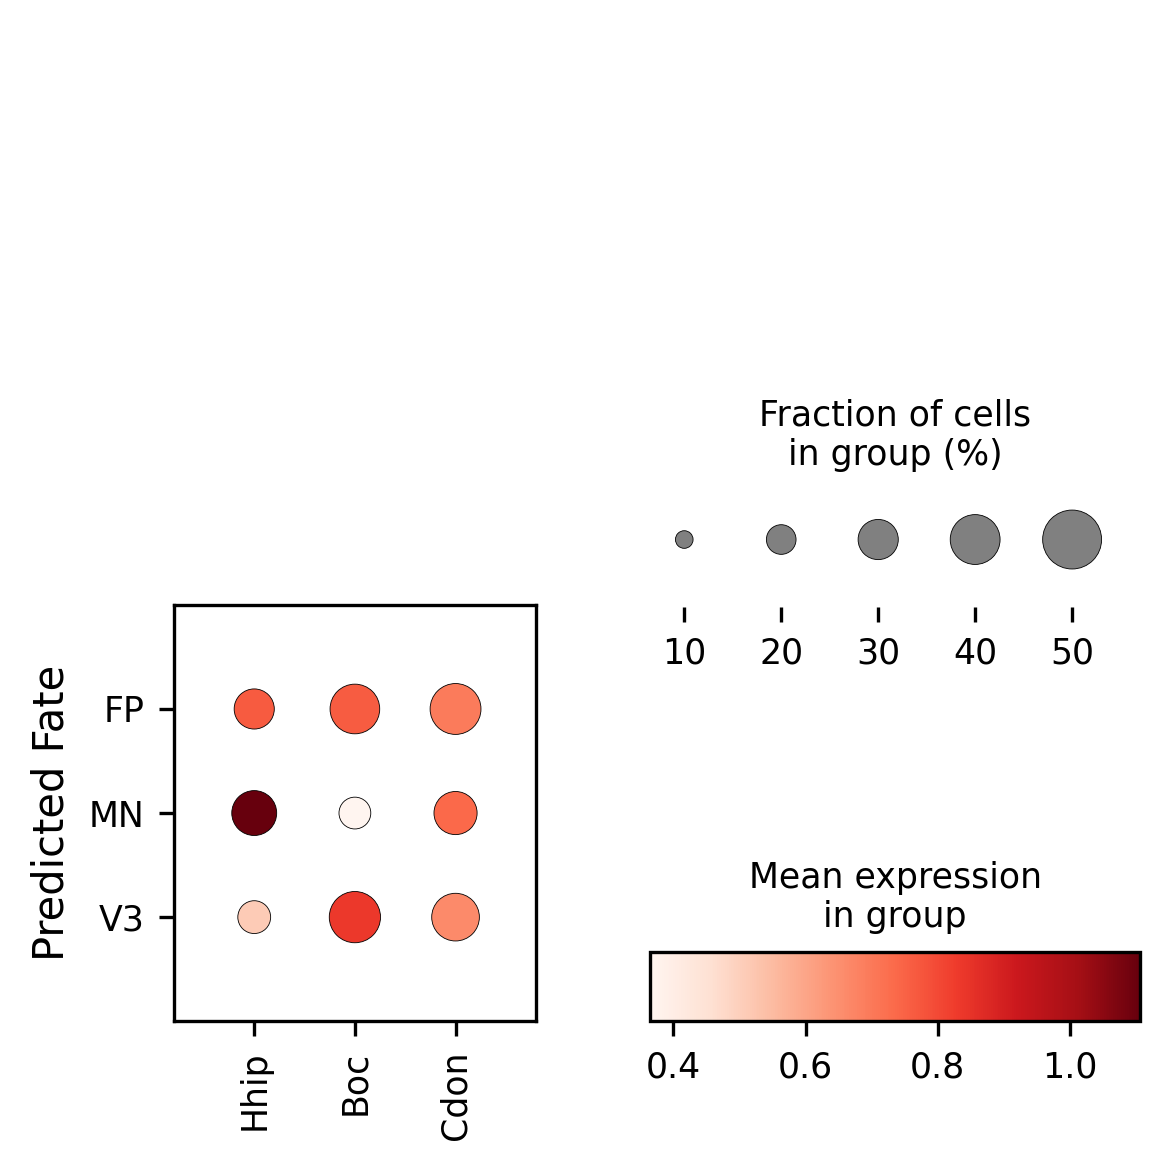

In [59]:
fig, ax = plt.subplots(dpi=300, figsize=(4,4,))
ax = sc.pl.dotplot(dat, groupby='FATE', var_names=['Hhip','Boc','Cdon'], ax=ax, show=False)

ax['mainplot_ax'].set_ylabel("Predicted Fate")

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
plt.tight_layout()
plt.savefig('../figures/4.0.9_dotplot_shh.png', bbox_inches='tight')

plt.show()